# Modelos GBMs e Avaliação de Performance

# Resumo

Neste notebook, foram avaliadas dois modelos baseados em Gradient Boosting (LightGBM e XGBoost). A análise contemplou métricas de validação cruzada, curvas de aprendizado, avaliação de estabilidade (gaps entre treino e validação) e curvas de desempenho no conjunto de holdout. 

Os resultados indicaram que o modelo de regressão logística apresentou desempenho competitivo e superior em termos de estabilidade e calibração, enquanto os modelos de boosting demonstraram sinais claros de overfitting, sem ganhos consistentes em discriminação global.

Apesar disso, os modelos de boosting não foram descartados neste estágio, uma vez que a decisão final de modelo será orientada por análise de risco, calibração e impacto econômico, e não apenas por métricas estatísticas agregadas.

# Objetivos

Comparar modelos lineares vs. modelos baseados em árvores (GBM)
com foco em performance preditiva, calibração e impacto operacional.

# Importando as Bibliotecas

In [45]:
# Manipulação de Dados
import numpy as np
import pandas as pd
import json
import joblib

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem, Validação e Pipelines
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    learning_curve,
    cross_val_predict,
)

# Pipelines
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb


# Pré-processamento
from sklearn.preprocessing import (
    StandardScaler,
    PowerTransformer
)


# Métricas e Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    make_scorer,
    brier_score_loss,
    log_loss,
    precision_recall_curve,
    average_precision_score,
    auc
)


# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    DATA_RAW, 
    DATA_PROCESSED,
    MODELS_ARTIFACTS_DIR,
    SPLITS_DIR,
    METRIC_ARTIFACTS_DIR
)
from evaluation.credit_gain import (
    credit_gain_score,
    make_credit_gain_scorer
)

# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)


pd.options.display.float_format = '{:.3f}'.format
np.set_printoptions(suppress=True, precision=3)

# Importandos a Base Tratada

In [46]:
df = pd.read_parquet(DATA_PROCESSED / "Base_Inadimplencia_Tratada.parquet")
df.head()

,Idade,Valor_Emprestimo,Duracao_Emprestimo,Escolaridade,Tipo_Moradia,Saldo_Investimento_Moderado,Saldo_Investimento_Pouco,Saldo_Investimento_Sem investimento,Saldo_Conta_Corrente_Moderado,Saldo_Conta_Corrente_Pouco,Saldo_Conta_Corrente_Sem conta,Inadimplencia
0,67,1169,6,1,0,0,0,1,0,1,0,0
1,22,5951,48,1,0,0,1,0,1,0,0,1
2,49,2096,12,0,0,0,1,0,0,0,1,0
3,45,7882,42,1,2,0,1,0,0,1,0,0
4,53,4870,24,1,2,0,1,0,0,1,0,1


# Importando o Pipeline Base (logit ElasticNet)

In [47]:
logit_pipe = joblib.load(
    MODELS_ARTIFACTS_DIR / "logit_pipe.joblib"
)

logit_pipe


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('yeojohnson', ...), ('scaler', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"method method: {'yeo-johnson', 'box-cox'}, default='yeo-johnson'The power transform method. Available methods are:- 'yeo-johnson' [1]_, works with positive and negative values- 'box-cox' [2]_, only works with strictly positive values",'yeo-johnson'
,"standardize standardize: bool, default=TrueSet to True to apply zero-mean, unit-variance normalization to thetransformed output.",True
,"copy copy: bool, default=TrueSet to False to perform inplace computation during transformation.",True
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'elasticnet'


# Importando a Métrica Econômica

In [48]:
with open(METRIC_ARTIFACTS_DIR / "payoff_config.json", "r") as f:
    payoff_config = json.load(f)

payoff_config

{'scenario': 'baseline_v1',
 'economic_assumptions': {'valor_medio_emprestimo': 3271.26,
  'margem_liquida': 0.1,
  'recovery_rate': 0.2,
  'custo_cobranca': 100.0},
 'derived_values': {'lucro_cliente_bom_formula': 'margem_liquida * valor_medio_emprestimo',
  'prejuizo_cliente_mau_formula': '(1 - recovery_rate) * valor_medio_emprestimo + custo_cobranca'},
 'payoff_matrix_definition': {'matrix_order': {'y_true': ['bom_pagador (0)',
    'inadimplente (1)'],
   'y_pred': ['aprova (0)', 'nega (1)']},
  'payoff_matrix': [[327.13, -327.13], [-2717.01, 0.0]]},
 'description': {'TP': 'Aprovação correta de cliente bom (lucro líquido)',
  'FP': 'Aprovação de cliente inadimplente (prejuízo)',
  'FN': 'Negação de cliente bom (custo de oportunidade)',
  'TN': 'Negação correta de cliente inadimplente'},
 'notes': 'Classe positiva = inadimplência (1). y_pred=1 implica negação de crédito.'}

In [49]:
payoff_matrix = np.array(
    payoff_config["payoff_matrix_definition"]["payoff_matrix"]
)

payoff_matrix

array([[  327.13,  -327.13],
       [-2717.01,     0.  ]])

In [50]:
credit_gain_scorer = make_credit_gain_scorer(
    payoff_matrix=payoff_matrix,
    threshold=0.5
)

# Configurando o Setup dos Dados

## Splits Estratificados

In [51]:
target = 'Inadimplencia'
X = df.drop(columns=[target])
y = df[target]

In [52]:
train_idx = np.load(SPLITS_DIR / "train_idx.npy")
test_idx  = np.load(SPLITS_DIR / "test_idx.npy")

X_train = X.loc[train_idx]
X_test  = X.loc[test_idx]

y_train = y.loc[train_idx]
y_test  = y.loc[test_idx]

In [53]:
with open(SPLITS_DIR / "cv_folds.json", "r") as f:
    cv_folds = json.load(f)

len(cv_folds)

for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    break


## Estratégia de Validação

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Dicionário de Scores

In [55]:
# definindo o score KS
ks_scorer = make_scorer(
    af.ks_stat,
    response_method="predict_proba"
)

# definindo o score Brier
brier_scorer = make_scorer(
    brier_score_loss,
    greater_is_better=False,
    response_method="predict_proba"
)


precision_scorer = make_scorer(precision_score, zero_division=0)
recall_scorer = make_scorer(recall_score, zero_division=0)
f1_scorer = make_scorer(f1_score, zero_division=0)

scoring_model_selection = {
    'AUC': 'roc_auc',
    'KS': ks_scorer,
    'LogLoss': make_scorer(
        log_loss,
        greater_is_better=False,
        response_method='predict_proba'
    )
}


scoring_calibration = {
    'Brier': brier_scorer
}


scoring_diagnostics = {
    'Precision': precision_scorer,
    'Recall': recall_scorer,
    'F1': f1_scorer
}


scoring_business = {
    'Gain_mean': credit_gain_scorer
}


# definindo o dicionario de scores final
scoring = {
    **scoring_model_selection,
    **scoring_calibration,
    **scoring_diagnostics,
    **scoring_business
}

# Baseline - Regressão Logística (ElasticNet)

## Métricas - CrossValidate

In [56]:
logit_results = cross_validate(
    logit_pipe,
    X_train,
    y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True
)


df_logit_results = pd.DataFrame(logit_results)
df_logit_results

,fit_time,score_time,test_AUC,train_AUC,test_KS,train_KS,test_LogLoss,train_LogLoss,test_Brier,train_Brier,test_Precision,train_Precision,test_Recall,train_Recall,test_F1,train_F1,test_Gain_mean,train_Gain_mean
0,0.037,0.008,0.802,0.769,0.544,0.448,-0.551,-0.578,-0.185,-0.197,0.531,0.490,0.810,0.768,0.642,0.599,-66.465,-116.784
1,0.033,0.007,0.761,0.779,0.486,0.472,-0.613,-0.568,-0.210,-0.193,0.456,0.500,0.738,0.750,0.564,0.600,-157.400,-121.993
2,0.033,0.007,0.732,0.787,0.480,0.474,-0.587,-0.560,-0.199,-0.190,0.508,0.508,0.714,0.768,0.594,0.611,-139.421,-106.270
3,0.035,0.006,0.687,0.791,0.330,0.477,-0.657,-0.555,-0.232,-0.187,0.405,0.524,0.714,0.768,0.517,0.623,-209.520,-96.923
4,0.036,0.007,0.780,0.769,0.483,0.440,-0.556,-0.577,-0.189,-0.197,0.516,0.483,0.786,0.750,0.623,0.587,-90.546,-132.508


In [57]:
def summarize_cv(
    cv_results,
    metrics_direction=None,
    relative_gap=True
):
    """
    Resume resultados de cross_validate com cálculo de gap treino-validação.

    Parameters
    ----------
    cv_results : dict
        Output do sklearn.model_selection.cross_validate
    metrics_direction : dict
        Direção esperada das métricas.
        Ex: {'AUC': 'max', 'LogLoss': 'min'}
    relative_gap : bool
        Se True, calcula gap relativo (%)

    Returns
    -------
    pd.DataFrame
    """

    rows = {}

    for key in cv_results:
        if not key.startswith("test_"):
            continue

        metric = key.replace("test_", "")
        test_scores = cv_results[key]
        train_scores = cv_results.get(f"train_{metric}")

        rows[metric] = {
            "train_mean": np.mean(train_scores) if train_scores is not None else np.nan,
            "train_std": np.std(train_scores) if train_scores is not None else np.nan,
            "val_mean": np.mean(test_scores),
            "val_std": np.std(test_scores),
        }

        if train_scores is not None:
            gap = rows[metric]["train_mean"] - rows[metric]["val_mean"]
            rows[metric]["gap_abs"] = gap

            if relative_gap:
                denom = abs(rows[metric]["train_mean"])
                rows[metric]["gap_rel_%"] = (gap / denom * 100) if denom != 0 else np.nan
        else:
            rows[metric]["gap_abs"] = np.nan
            rows[metric]["gap_rel_%"] = np.nan

    df = pd.DataFrame(rows).T

    # Ajuste semântico para métricas que devem ser minimizadas
    if metrics_direction:
        for metric, direction in metrics_direction.items():
            if metric in df.index and direction == "min":
                df.loc[metric, ["train_mean", "val_mean"]] *= -1
                df.loc[metric, ["gap_abs", "gap_rel_%"]] *= -1

    return df

In [58]:
metrics_direction = {
    "AUC": "max",
    "KS": "max",
    "LogLoss": "min",
    "F1": "max",
    "Precision": "max",
    "Recall": "max",
    "Brier": "min",
    "Gain_mean": "max"
}

summary_logit = summarize_cv(
    logit_results,
    metrics_direction=metrics_direction
)

summary_logit

,train_mean,train_std,val_mean,val_std,gap_abs,gap_rel_%
AUC,0.779,0.009,0.752,0.040,0.027,3.425
KS,0.462,0.015,0.465,0.071,-0.002,-0.515
LogLoss,0.568,0.009,0.593,0.039,-0.025,-4.442
Brier,0.193,0.004,0.203,0.017,-0.010,-5.304
Precision,0.501,0.014,0.483,0.046,0.018,3.547
Recall,0.761,0.009,0.752,0.039,0.008,1.095
F1,0.604,0.012,0.588,0.044,0.016,2.698
Gain_mean,-114.896,12.342,-132.670,50.439,17.775,15.470


In [59]:
# Gerando previsões OOF para o modelo de Regressão Logística
oof_preds_logit = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    logit_pipe.fit(X_tr, y_tr)

    oof_preds_logit[val_idx] = logit_pipe.predict_proba(X_val)[:, 1]

## Métrica Econômica

In [60]:
y_test_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

gain_baseline = credit_gain_score(
    y_true=y_test,
    y_score=y_test_proba_logit,
    threshold=0.5,
    payoff_matrix=payoff_matrix
)

gain_baseline

np.float64(-116.70769999999999)

# Modelo Performance GBM (LightGBM e XGBM)

## LightGBM

In [61]:
# definindo o classificador LightGBM
lgb_clf = lgb.LGBMClassifier(
    objective="binary",
    n_estimators=300,
    class_weight='balanced',
    subsample=0.5,
    colsample_bytree=0.5,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# criando o pipeline LightGBM
lgb_pipe = Pipeline(
    steps=[
        ("model", lgb_clf)
    ]
)

In [62]:
# avaliando o LightGBM com cross-validation
cv_results_lgb = cross_validate(
    estimator=lgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# criando DataFrame com os resultados do LightGBM
df_lgb_results = pd.DataFrame(cv_results_lgb)

# resumindo os resultados do LightGBM
summary_lgb = summarize_cv(
    cv_results_lgb,
    metrics_direction=metrics_direction
)

summary_lgb

,train_mean,train_std,val_mean,val_std,gap_abs,gap_rel_%
AUC,1.000,0.000,0.724,0.058,0.276,27.570
KS,1.000,0.000,0.390,0.076,0.610,61.020
LogLoss,0.061,0.009,0.785,0.166,-0.725,-1190.872
Brier,0.008,0.002,0.215,0.030,-0.207,-2741.883
Precision,0.994,0.005,0.528,0.057,0.466,46.889
Recall,1.000,0.000,0.529,0.063,0.471,47.143
F1,0.997,0.003,0.528,0.060,0.469,47.023
Gain_mean,227.823,1.045,-247.803,60.844,475.626,208.770


In [63]:
# gerando previsões out-of-fold (OOF) para LightGBM
oof_preds_lgb = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    # fit
    lgb_pipe.fit(X_tr, y_tr)

    # predict OOF
    oof_preds_lgb[val_idx] = lgb_pipe.predict_proba(X_val)[:, 1]

In [64]:
# Gerando as previsões no Holdout para o LightGBM
lgb_pipe.fit(X_train, y_train)
y_test_proba_lgb = lgb_pipe.predict_proba(X_test)[:, 1]

In [65]:
# checando valores mínimos e máximos das previsões OOF ideal -> [0,1]
oof_preds_lgb.min(), oof_preds_lgb.max()

(np.float64(2.3751373681879382e-05), np.float64(0.9989727211563031))

In [66]:
# checando valores mínimos e máximos das previsões no Holdout ideal -> [0,1]
y_test_proba_lgb.min(), y_test_proba_lgb.max()

(np.float64(5.160283015829688e-05), np.float64(0.9997777667045784))

## XGBM

In [67]:
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

scale_pos_weight = n_neg / n_pos


xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    n_estimators=300,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.5,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    verbose=0
)

xgb_pipe = Pipeline(
    steps=[
        ("model", xgb_clf)
    ]
)

In [68]:
cv_results_xgb = cross_validate(
    estimator=xgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=True
)

# criando DataFrame com os resultados do XGBoost
df_xgb_results = pd.DataFrame(cv_results_xgb)

# resumindo os resultados do XGBoost
summary_xgb = summarize_cv(
    cv_results_xgb,
    metrics_direction=metrics_direction
)

summary_xgb

,train_mean,train_std,val_mean,val_std,gap_abs,gap_rel_%
AUC,0.995,0.001,0.733,0.065,0.262,26.325
KS,0.945,0.011,0.427,0.085,0.518,54.788
LogLoss,0.202,0.010,0.609,0.095,-0.408,-202.079
Brier,0.048,0.003,0.196,0.029,-0.148,-309.553
Precision,0.907,0.009,0.542,0.080,0.365,40.271
Recall,0.976,0.012,0.581,0.082,0.395,40.488
F1,0.940,0.003,0.560,0.077,0.380,40.458
Gain_mean,189.956,7.794,-209.780,80.911,399.736,210.436


In [69]:
# gerando previsões out-of-fold (OOF) para XGBoost
oof_preds_xgb = np.zeros(len(X_train))
for fold in cv_folds:
    tr_idx = fold["train_idx"]
    val_idx = fold["val_idx"]

    X_tr = X_train.iloc[tr_idx]
    y_tr = y_train.iloc[tr_idx]

    X_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]

    xgb_pipe.fit(X_tr, y_tr)

    oof_preds_xgb[val_idx] = xgb_pipe.predict_proba(X_val)[:, 1]

In [70]:
# Gerando as previsões no Holdout para o XGBoost
xgb_pipe.fit(X_train, y_train)
y_test_proba_xgb = xgb_pipe.predict_proba(X_test)[:, 1]

In [71]:
# checando valores mínimos e máximos das previsões OOF ideal -> [0,1]
oof_preds_xgb.min(), oof_preds_xgb.max()

(np.float64(0.0032845453824847937), np.float64(0.9881195425987244))

In [72]:
# checando valores mínimos e máximos das previsões no Holdout ideal -> [0,1]
y_test_proba_xgb.min(), y_test_proba_xgb.max()

(np.float32(0.0024734242), np.float32(0.96645045))

## Comparação Consolidada - GBMs vs Logit

### Tabela Resumo - Métricas CV

In [73]:
def extract_cv_metrics(cv_results):
    return {
        "AUC (val)": np.mean(cv_results["test_AUC"]),
        "KS (val)": np.mean(cv_results["test_KS"]),
        "LogLoss (val)": -np.mean(cv_results["test_LogLoss"]),
        "Brier (val)": -np.mean(cv_results["test_Brier"]),
        "Gain_mean (val)": np.mean(cv_results["test_Gain_mean"]),
    }


In [74]:
def calc_cv_gap(cv_results, metric_name):
    """
    Calcula o gap absoluto entre treino e validação (CV),
    em pontos percentuais.
    """
    train_mean = np.mean(cv_results[f"train_{metric_name}"])
    val_mean   = np.mean(cv_results[f"test_{metric_name}"])

    return abs(train_mean - val_mean) * 100



In [75]:
def ks_statistic(y_true, y_score):
    data = pd.DataFrame({
        "y_true": y_true,
        "y_score": y_score
    }).sort_values("y_score", ascending=False)

    data["cum_pos"] = (data["y_true"] == 1).cumsum() / (data["y_true"] == 1).sum()
    data["cum_neg"] = (data["y_true"] == 0).cumsum() / (data["y_true"] == 0).sum()

    return np.max(np.abs(data["cum_pos"] - data["cum_neg"]))


In [76]:
# Calculando métricas OOF e Holdout para cada modelo
# Logística
auc_oof_logit = roc_auc_score(y_train, oof_preds_logit)
auc_test_logit = roc_auc_score(y_test, y_test_proba_logit)
ks_oof_logit  = ks_statistic(y_train, oof_preds_logit)
ks_test_logit  = ks_statistic(y_test, y_test_proba_logit)

# LightGBM
auc_oof_lgb = roc_auc_score(y_train, oof_preds_lgb)
auc_test_lgb = roc_auc_score(y_test, y_test_proba_lgb)
ks_oof_lgb  = ks_statistic(y_train, oof_preds_lgb)
ks_test_lgb  = ks_statistic(y_test, y_test_proba_lgb)

# XGBoost
auc_oof_xgb = roc_auc_score(y_train, oof_preds_xgb)
auc_test_xgb = roc_auc_score(y_test, y_test_proba_xgb)
ks_oof_xgb  = ks_statistic(y_train, oof_preds_xgb)
ks_test_xgb  = ks_statistic(y_test, y_test_proba_xgb)

In [77]:
rows = []

# Logística
row_logit = {
    "Modelo": "Logit ElasticNet"
}
row_logit.update(extract_cv_metrics(logit_results))
row_logit["Gap AUC (%)"] = calc_cv_gap(logit_results, "AUC")
row_logit["Gap KS (%)"]  = calc_cv_gap(logit_results, "KS")

rows.append(row_logit)


# LightGBM
row_lgb = {
    "Modelo": "LightGBM"
}
row_lgb.update(extract_cv_metrics(cv_results_lgb))
row_lgb["Gap AUC (%)"] = calc_cv_gap(cv_results_lgb, "AUC")
row_lgb["Gap KS (%)"]  = calc_cv_gap(cv_results_lgb, "KS")

rows.append(row_lgb)

# XGBoost
row_xgb = {
    "Modelo": "XGBoost"
}
row_xgb.update(extract_cv_metrics(cv_results_xgb))
row_xgb["Gap AUC (%)"] = calc_cv_gap(cv_results_xgb, "AUC")
row_xgb["Gap KS (%)"]  = calc_cv_gap(cv_results_xgb, "KS")

rows.append(row_xgb)

df_model_comparison = pd.DataFrame(rows)


In [78]:
df_model_comparison = (
    df_model_comparison
        .set_index("Modelo")
        .round(3)
        .sort_values("AUC (val)", ascending=False)
)

df_model_comparison


,AUC (val),KS (val),LogLoss (val),Brier (val),Gain_mean (val),Gap AUC (%),Gap KS (%)
Modelo,,,,,,,
Logit ElasticNet,0.752,0.465,0.593,0.203,-132.670,2.668,0.238
XGBoost,0.733,0.427,0.609,0.196,-209.780,26.193,51.769
LightGBM,0.724,0.390,0.785,0.215,-247.803,27.570,61.020


### Estabilidade - Learning Curve

In [79]:
def get_learning_curve_data(
    estimator,
    X,
    y,
    cv,
    scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
):
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=estimator,
        X=X,
        y=y,
        cv=cv,
        scoring=scoring,
        train_sizes=train_sizes,
        n_jobs=n_jobs,
        shuffle=True,
        random_state=42
    )

    df = pd.DataFrame({
        "Train Size": train_sizes_abs,

        "Train Mean": train_scores.mean(axis=1),
        "Train Std": train_scores.std(axis=1),

        "Validation Mean": val_scores.mean(axis=1),
        "Validation Std": val_scores.std(axis=1),
    })

    return df


In [80]:
lc_logit = get_learning_curve_data(
    estimator=logit_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)

lc_lgb = get_learning_curve_data(
    estimator=lgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)

lc_xgb = get_learning_curve_data(
    estimator=xgb_pipe,
    X=X_train,
    y=y_train,
    cv=cv
)


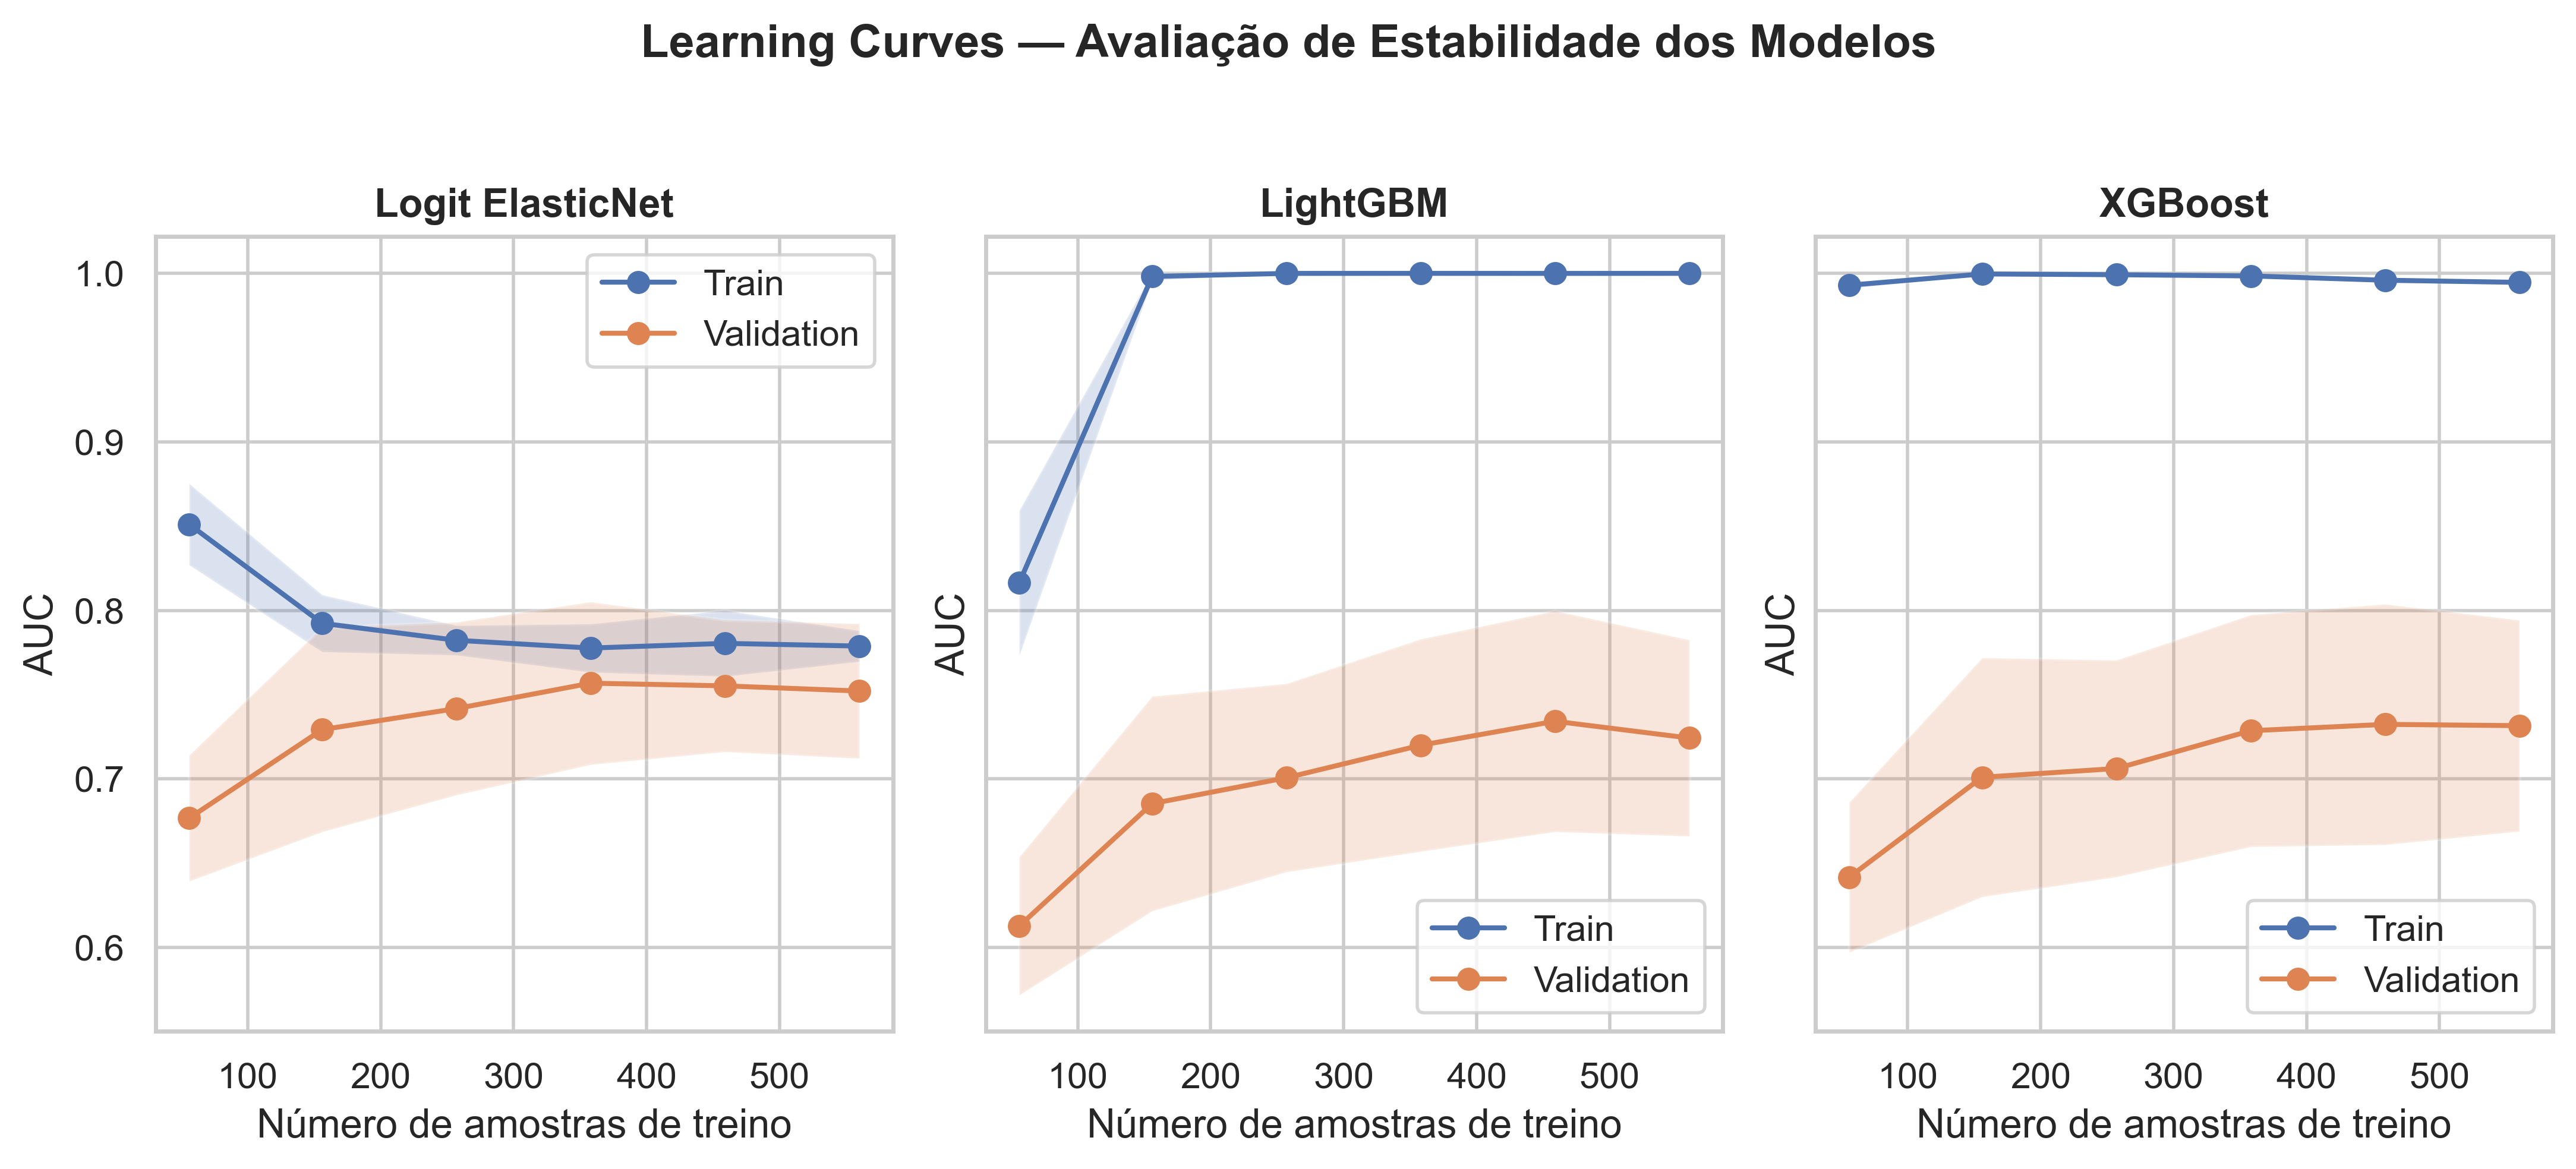

In [81]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(11, 5),
    sharey=True
)

models_data = [
    ("Logit ElasticNet", lc_logit),
    ("LightGBM", lc_lgb),
    ("XGBoost", lc_xgb)
]

for ax, (title, df) in zip(axes, models_data):

    # ---- Train curve ----
    ax.plot(
        df["Train Size"],
        df["Train Mean"],
        marker="o",
        label="Train",
    )

    ax.fill_between(
        df["Train Size"],
        df["Train Mean"] - df["Train Std"],
        df["Train Mean"] + df["Train Std"],
        alpha=0.2
    )

    # ---- Validation curve ----
    ax.plot(
        df["Train Size"],
        df["Validation Mean"],
        marker="o",
        label="Validation",
    )

    ax.fill_between(
        df["Train Size"],
        df["Validation Mean"] - df["Validation Std"],
        df["Validation Mean"] + df["Validation Std"],
        alpha=0.2
    )

    ax.set_title(title, fontsize=12, weight="bold")
    ax.set_xlabel("Número de amostras de treino")
    ax.set_ylabel("AUC")
    ax.legend()

plt.suptitle(
    "Learning Curves — Avaliação de Estabilidade dos Modelos",
    fontsize=14,
    weight="bold"
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### AUC-ROC, PR-AUC e KS curve

In [82]:
def compute_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc


def compute_pr(y_true, y_score):
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    return recall, precision, ap


def compute_ks(y_true, y_score):
    """
    Calcula a curva KS a partir da curva ROC.
    Retorna:
    - fpr
    - ks_curve = tpr - fpr
    - ks_stat
    """
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ks_curve = tpr - fpr
    ks_stat = np.max(ks_curve)

    return fpr, ks_curve, ks_stat


In [83]:
# ROC
roc_logit = compute_roc(y_test, y_test_proba_logit)
roc_lgb   = compute_roc(y_test, y_test_proba_lgb)
roc_xgb   = compute_roc(y_test, y_test_proba_xgb)

# Precision-Recall
pr_logit = compute_pr(y_test, y_test_proba_logit)
pr_lgb   = compute_pr(y_test, y_test_proba_lgb)
pr_xgb   = compute_pr(y_test, y_test_proba_xgb)


# KS
ks_logit = compute_ks(y_test, y_test_proba_logit)
ks_lgb   = compute_ks(y_test, y_test_proba_lgb)
ks_xgb   = compute_ks(y_test, y_test_proba_xgb)


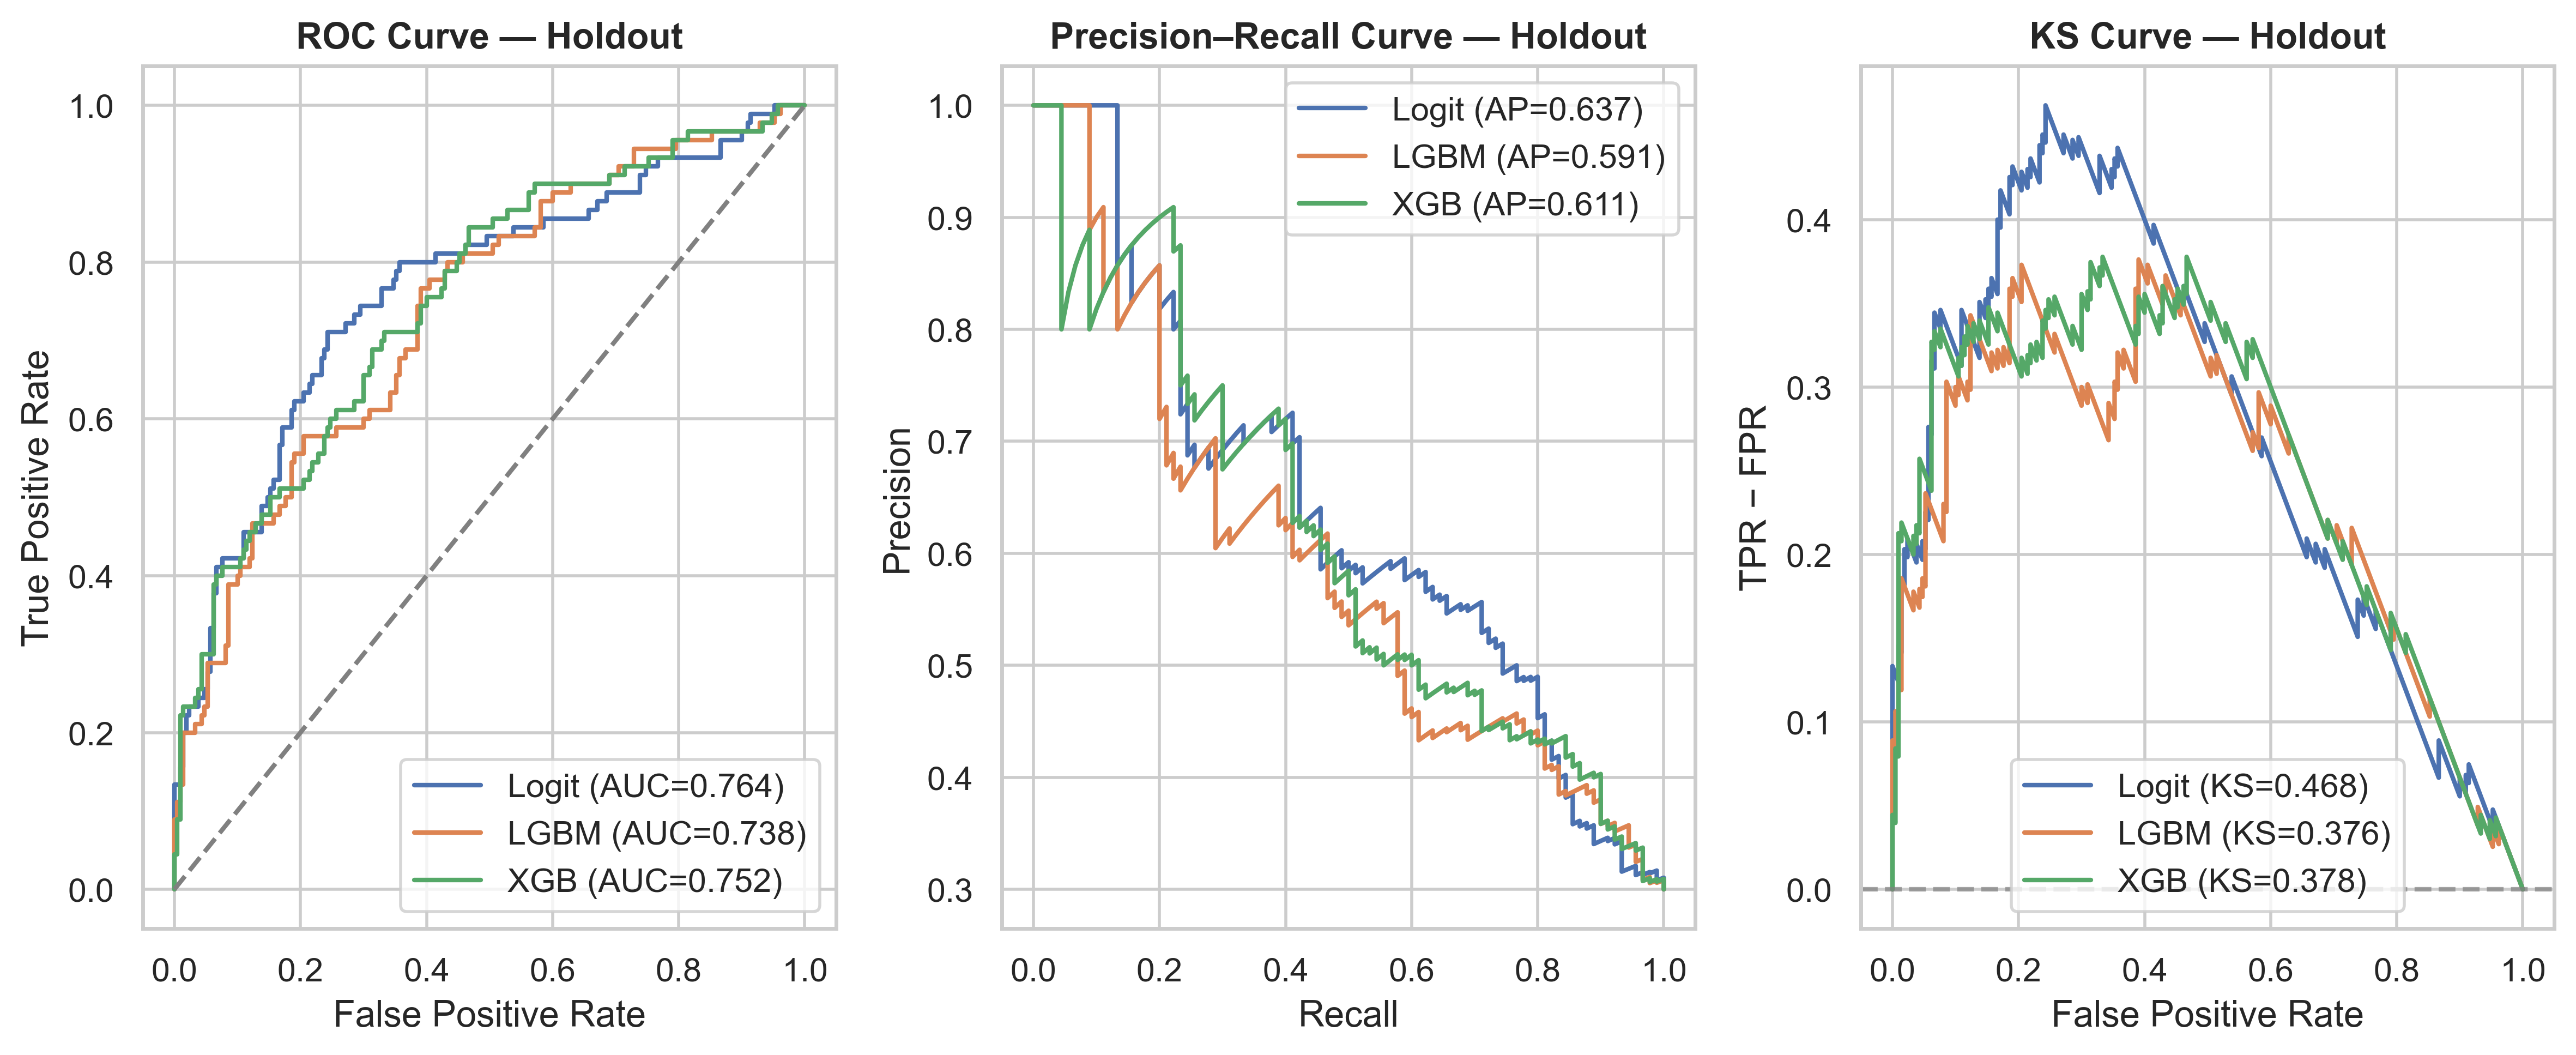

In [84]:
sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    figsize=(12, 5)
)

# =========================
# 1️⃣ ROC-AUC
# =========================
axes[0].plot(roc_logit[0], roc_logit[1], label=f"Logit (AUC={roc_logit[2]:.3f})")
axes[0].plot(roc_lgb[0],   roc_lgb[1],   label=f"LGBM (AUC={roc_lgb[2]:.3f})")
axes[0].plot(roc_xgb[0],   roc_xgb[1],   label=f"XGB (AUC={roc_xgb[2]:.3f})")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")

axes[0].set_title("ROC Curve — Holdout", weight="bold")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()

# =========================
# 2️⃣ Precision–Recall
# =========================
axes[1].plot(pr_logit[0], pr_logit[1], label=f"Logit (AP={pr_logit[2]:.3f})")
axes[1].plot(pr_lgb[0],   pr_lgb[1],   label=f"LGBM (AP={pr_lgb[2]:.3f})")
axes[1].plot(pr_xgb[0],   pr_xgb[1],   label=f"XGB (AP={pr_xgb[2]:.3f})")

axes[1].set_title("Precision–Recall Curve — Holdout", weight="bold")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()

# =========================
# 3️⃣ KS Curve
# =========================
axes[2].plot(
    ks_logit[0],
    ks_logit[1],
    label=f"Logit (KS={ks_logit[2]:.3f})"
)

axes[2].plot(
    ks_lgb[0],
    ks_lgb[1],
    label=f"LGBM (KS={ks_lgb[2]:.3f})"
)

axes[2].plot(
    ks_xgb[0],
    ks_xgb[1],
    label=f"XGB (KS={ks_xgb[2]:.3f})"
)

axes[2].axhline(0, linestyle="--", color="gray", alpha=0.7)

axes[2].set_title("KS Curve — Holdout", weight="bold")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("TPR − FPR")
axes[2].legend()


plt.tight_layout()
plt.show()


## Conclusão

A análise comparativa entre os modelos evidencia que a Regressão Logística com regularização ElasticNet apresenta desempenho competitivo e consistente frente aos modelos baseados em Gradient Boosting. O modelo logístico alcança os melhores resultados em termos de AUC e KS médios na validação cruzada, além de exibir as menores perdas probabilísticas (LogLoss e Brier), indicando melhor calibração das probabilidades estimadas. Adicionalmente, os baixos gaps entre as métricas de treino e validação sugerem elevada estabilidade e baixo risco de overfitting. Em contraste, tanto o XGBoost quanto o LightGBM apresentam gaps substancialmente maiores, sinalizando overfitting severo no processo de validação cruzada, sem ganhos claros em discriminação ou calibração. Esses resultados indicam que, neste estágio, o modelo ElasticNet constitui um baseline robusto e altamente competitivo, sendo uma referência sólida para as análises subsequentes de risco e decisão.

# Considerações Finais

Nesta etapa, os modelos são avaliados como arquiteturas candidatas, e não como versões finais de produção. Mesmo modelos que apresentam sinais de overfitting na validação cruzada são levados para a análise de risco e decisão, uma vez que o processo decisório envolve calibração, definição de thresholds e otimização econômica. A escolha da arquitetura precede a etapa de tunagem de hiperparâmetros, que será realizada apenas para o modelo selecionado como candidato à produção.

# Exportando...

## Modelos GBMs

In [85]:
joblib.dump(
    lgb_pipe,
    MODELS_ARTIFACTS_DIR / "lgb_pipe.joblib"
)

joblib.dump(
    xgb_pipe,
    MODELS_ARTIFACTS_DIR / "xgb_pipe.joblib"
)

['C:\\Users\\jooar\\ds\\portfolio\\credit-default-prediction\\artifacts\\models\\xgb_pipe.joblib']

# Próximos Passos

No próximo notebook, os modelos avaliados neste estágio serão levados para uma análise orientada à decisão, com foco em risco e impacto econômico. As principais etapas previstas incluem:

- Avaliação e ajuste de calibração das probabilidades previstas;
- Análise de sensibilidade em relação ao limiar de decisão (threshold);
- Estudo de diferentes estratégias de balanceamento e seus impactos no risco;
- Avaliação do trade-off entre métricas estatísticas e métricas econômicas;
- Comparação dos modelos sob cenários de decisão realistas, considerando custos de erro e payoff esperado.

A partir dessa análise, será selecionada a arquitetura de modelo mais adequada para o problema. Apenas então, caso um modelo baseado em Gradient Boosting seja escolhido, será realizada uma etapa adicional de otimização de hiperparâmetros, visando refinar o desempenho dentro da arquitetura selecionada.
